# Day-Ahead Solar Forecasting (NSRDB, Metro Manila)

In this notebook, I build a **day-ahead** forecasting pipeline for **Global Horizontal Irradiance (GHI)** using hourly data from the **NREL National Solar Radiation Database (NSRDB)**. I use GHI as a physically meaningful proxy for solar PV potential, then convert the irradiance forecast into an estimated PV power output using a simple efficiency model.

**Forecasting task (day-ahead):** predict tomorrow’s hourly irradiance (t+24 hours) using only information available at time *t*. This avoids inflated performance that can occur in hour-ahead forecasting due to short-term persistence.

## What is GHI?

**Global Horizontal Irradiance (GHI)** is the total shortwave solar radiation received per unit area on a horizontal surface at the Earth’s surface (typically in W/m²). It can be decomposed into direct-beam and diffuse components:

$$
GHI = DNI \times \cos(\theta_z) + DHI
$$

where:
- $DNI$ is Direct Normal Irradiance (beam radiation from the sun),
- $DHI$ is Diffuse Horizontal Irradiance (scattered radiation),
- $\theta_z$ is the solar zenith angle.

## Dataset (NSRDB)

NSRDB is maintained by **NREL** and provides gridded solar radiation and meteorological variables derived from satellite observations, numerical weather models, and radiative transfer methods. I downloaded hourly (60‑min) CSV files for **2019–2020** for a point in **Metropolitan Manila, Philippines**.

## Scope and limitations

- I forecast **GHI** (irradiance), not measured PV power. PV conversion here is simplified (fixed efficiency; no tilt/orientation losses; no inverter clipping).
- This is a **single-location** demonstration. Generalization to other sites requires retraining.
- Day-ahead skill is fundamentally limited by **cloud variability**; adding satellite cloud products or NWP forecasts would likely improve performance.

## References
- NREL NSRDB Viewer: https://nsrdb.nrel.gov/nsrdb-viewer  
- NREL NSRDB: https://nsrdb.nrel.gov/  
- SolarAnywhere data field definitions: https://www.solaranywhere.com/support/data-fields/definitions/


![DHI and DNI](figures/DHI_DNI.png)

---
## The National Solar Radiation Database (NSRDB)

The **National Solar Radiation Database (NSRDB)** is a publicly available dataset developed and maintained by the **U.S. National Renewable Energy Laboratory (NREL)**. It provides gridded estimates of solar radiation and meteorological variables derived from satellite observations, numerical weather prediction models, and radiative transfer calculations.

The NSRDB data used in this project have the following key characteristics:

- **Hourly temporal resolution**
- **High spatial resolution (approximately 2 km for Asia–Pacific regions)**
- Consistent quality control across years
- Coverage of both radiative and meteorological variables relevant to solar energy applications

NSRDB data are widely used in solar resource assessment, PV system design, power forecasting research, and grid-integration studies.

---

## Selected Variables and Physical Rationale

The following variables are used as predictors in this study:

### Radiative variables
- **Global Horizontal Irradiance (GHI)**  
  Used as the forecast target and a proxy for solar PV output  
- **Direct Normal Irradiance (DNI)**  
  Indicates the strength of direct solar radiation under clear-sky conditions  
- **Diffuse Horizontal Irradiance (DHI)**  
  Captures cloud and aerosol scattering effects  
- **Clear-sky GHI**  
  Represents the theoretical irradiance under cloud-free conditions and enables separation of cloud-driven variability

### Meteorological variables
- **Air temperature**  
  Influences atmospheric density and PV efficiency  
- **Relative humidity**  
  Serves as a proxy for atmospheric moisture and cloud formation  
- **Wind speed**  
  Related to boundary-layer mixing and cloud evolution processes

### Time and persistence features
- **Hour of day, day of year, and month**  
  Capture deterministic solar geometry and seasonal cycles  
- **Lagged GHI (t−1 and t−24 hours)**  
  Represent short-term persistence and diurnal repeatability  
- **Rolling averages of GHI**  
  Smooth high-frequency variability and encode recent atmospheric states

Together, these features encode both **physical drivers** and **statistical persistence**, which are essential for effective short-term solar forecasting.

---

## Project Scope

The scope of this project is to:

- Develop a reproducible data-science pipeline for **hourly solar irradiance forecasting**
- Compare a **persistence baseline** with machine-learning models
- Apply **time-aware train/test splitting** appropriate for time-series data
- Quantify forecast performance using **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**
- Identify dominant predictors using feature-importance analysis

The primary focus is on **hour-ahead to day-ahead forecasting**, which is directly relevant to operational energy planning and grid integration.

---

## Limitations

Several limitations of this study should be noted:

1. **Irradiance proxy**  
   The models forecast GHI rather than measured PV power. Actual PV output additionally depends on panel tilt, orientation, system efficiency, and losses.

2. **Single-location analysis**  
   Results are location-specific and may not generalize without retraining for other regions.

3. **Lack of explicit cloud-motion information**  
   Satellite cloud imagery and motion vectors, which can improve very short-term forecasts, are not included.

4. **Statistical modeling approach**  
   The models do not explicitly resolve physical cloud dynamics and instead rely on historical patterns and correlations.

Despite these limitations, the workflow reflects **industry-standard practice** for data-driven solar forecasting and provides a solid foundation for more advanced modeling approaches.

---


## Setup



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', 100)
plt.rcParams['figure.dpi'] = 130

# Make sure output folders exist (important for GitHub/GitHub Pages)
os.makedirs("data", exist_ok=True)
os.makedirs("figures", exist_ok=True)


In [2]:
# Define the paths to the data
DATA_PATHS = [
    'data/nsrdb_2019.csv',
    'data/nsrdb_2020.csv'
]

# Load and concatenate multiple yearly NSRDB files

dfs = []

for path in DATA_PATHS:
    assert os.path.exists(path), f"File not found: {path}"
    df_year = pd.read_csv(path)
    dfs.append(df_year)

df_raw = pd.concat(dfs, ignore_index=False)

print("Loaded rows:", len(df_raw))
df_raw.head()

Loaded rows: 17524


,Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,Clearsky DHI Units,Clearsky DNI Units,Clearsky GHI Units,Dew Point Units,DHI Units,DNI Units,GHI Units,Solar Zenith Angle Units,Temperature Units,Pressure Units,Relative Humidity Units,Precipitable Water Units,Wind Direction Units,Wind Speed Units,Cloud Type -15,Cloud Type 0,Cloud Type 1,Cloud Type 2,Cloud Type 3,Cloud Type 4,Cloud Type 5,Cloud Type 6,Cloud Type 7,Cloud Type 8,Cloud Type 9,Cloud Type 10,Cloud Type 11,Cloud Type 12,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Surface Albedo Units,Version
0,NSRDB,4954849,-,b'Metropolitan Manila',b'Philippines',14.6,120.97,0,10,8,w/m2,w/m2,w/m2,c,w/m2,w/m2,w/m2,Degree,c,mbar,%,cm,Degrees,m/s,NaN,Clear,Probably Clear,Fog,Water,Super-Cooled Water,Mixed,Opaque Ice,Cirrus,Overlapping,Overshooting,Unknown,Dust,Smoke,NaN,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,NaN,unknown
1,Year,Month,Day,Hour,Minute,Temperature,Clearsky GHI,GHI,DNI,DHI,Relative Humidity,Wind Direction,Wind Speed,Surface Albedo,Cloud Type,Clearsky DNI,Clearsky DHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019,1,1,0,0,26,272,272,399,132,93.57000000000001,70,2.4000000000000004,0.1,1,399,132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019,1,1,1,0,26.5,472,248,47,223,91.99,69,2.7,0.1,2,576,165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019,1,1,2,0,27.1,633,313,41,286,88.52,69,3.1,0.1,3,666,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Load raw CSV (per year already concatenated)
df_raw = df_raw.reset_index(drop=True)

# Step 1: Extract the true header row (row index 1)
new_columns = df_raw.iloc[1].values
df_clean = df_raw.iloc[2:].copy()

# Step 2: Assign proper column names
df_clean.columns = new_columns

# Step 3: Reset index
df_clean = df_clean.reset_index(drop=True)

# Step 4: Convert numeric columns safely 

for col in df_clean.columns:
    try:
        df_clean[col] = pd.to_numeric(df_clean[col])
    except (ValueError, TypeError):
        # Leave non-numeric columns (e.g. Cloud Type) untouched
        pass

df_clean.head()


,Year,Month,Day,Hour,Minute,Temperature,Clearsky GHI,GHI,DNI,DHI,Relative Humidity,Wind Direction,Wind Speed,Surface Albedo,Cloud Type,Clearsky DNI,Clearsky DHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2019,1,1,0,0,26,272,272,399,132,93.57000000000001,70,2.4000000000000004,0.1,1,399,132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,1,1,1,0,26.5,472,248,47,223,91.99,69,2.7,0.1,2,576,165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019,1,1,2,0,27.1,633,313,41,286,88.52,69,3.1,0.1,3,666,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019,1,1,3,0,27.700000000000003,744,442,94,371,84.39,71,3.4000000000000004,0.1,3,743,178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019,1,1,4,0,28.200000000000003,779,540,174,402,81.14,74,3.6,0.1,3,753,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Explicitly convert known numeric columns to numeric types

numeric_cols = [
    'Year', 'Month', 'Day', 'Hour', 'Minute',
    'Temperature',
    'Clearsky GHI', 'GHI', 'DNI', 'DHI',
    'Relative Humidity',
    'Wind Direction', 'Wind Speed'
]

for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

df_clean.dtypes


Year                 float64
Month                float64
Day                  float64
Hour                 float64
Minute               float64
Temperature          float64
Clearsky GHI         float64
GHI                  float64
DNI                  float64
DHI                  float64
Relative Humidity    float64
Wind Direction       float64
Wind Speed           float64
Surface Albedo        object
Cloud Type            object
Clearsky DNI          object
Clearsky DHI          object
NaN                   object
NaN                   object
NaN                   object
NaN                   object
NaN                   object
NaN                   object
NaN                   object
NaN                  float64
NaN                   object
NaN                   object
NaN                   object
NaN                   object
NaN                   object
NaN                   object
NaN                   object
NaN                   object
NaN                   object
NaN           

In [5]:
# Select columns needed as provided above
df = df_clean[['Year','Month','Day','Hour','Minute','Temperature','Clearsky GHI','GHI',
               'DNI','DHI','Relative Humidity','Wind Direction','Wind Speed']]
df.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky GHI,GHI,DNI,DHI,Relative Humidity,Wind Direction,Wind Speed
0,2019.0,1.0,1.0,0.0,0.0,26.0,272.0,272.0,399.0,132.0,93.57,70.0,2.4
1,2019.0,1.0,1.0,1.0,0.0,26.5,472.0,248.0,47.0,223.0,91.99,69.0,2.7
2,2019.0,1.0,1.0,2.0,0.0,27.1,633.0,313.0,41.0,286.0,88.52,69.0,3.1
3,2019.0,1.0,1.0,3.0,0.0,27.7,744.0,442.0,94.0,371.0,84.39,71.0,3.4
4,2019.0,1.0,1.0,4.0,0.0,28.2,779.0,540.0,174.0,402.0,81.14,74.0,3.6


In [6]:
# Inspect missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17522 entries, 0 to 17521
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               17520 non-null  float64
 1   Month              17521 non-null  float64
 2   Day                17520 non-null  float64
 3   Hour               17520 non-null  float64
 4   Minute             17520 non-null  float64
 5   Temperature        17521 non-null  float64
 6   Clearsky GHI       17521 non-null  float64
 7   GHI                17521 non-null  float64
 8   DNI                17521 non-null  float64
 9   DHI                17521 non-null  float64
 10  Relative Humidity  17520 non-null  float64
 11  Wind Direction     17520 non-null  float64
 12  Wind Speed         17520 non-null  float64
dtypes: float64(13)
memory usage: 1.7 MB


In [7]:
df.columns.to_list()

['Year',
 'Month',
 'Day',
 'Hour',
 'Minute',
 'Temperature',
 'Clearsky GHI',
 'GHI',
 'DNI',
 'DHI',
 'Relative Humidity',
 'Wind Direction',
 'Wind Speed']

## Parse datetime
NSRDB exports often include columns like `Year`, `Month`, `Day`, `Hour`, `Minute`.

This cell tries to build a `datetime` index.


In [8]:
df = df.copy()

# Try to build a datetime column from common NSRDB fields
possible_parts = ['Year', 'Month', 'Day', 'Hour', 'Minute']
has_parts = all(col in df.columns for col in ['Year', 'Month', 'Day', 'Hour'])

if has_parts:
    if 'Minute' not in df.columns:
        df['Minute'] = 0
    df['dt'] = pd.to_datetime(
        dict(year=df['Year'], month=df['Month'], day=df['Day'], hour=df['Hour'], minute=df['Minute']),
        errors='coerce'
    )
elif 'datetime' in df.columns:
    df['dt'] = pd.to_datetime(df['datetime'], errors='coerce')
elif 'time' in df.columns:
    df['dt'] = pd.to_datetime(df['time'], errors='coerce')
else:
    # If this fails, print columns and manually set parsing.
    raise ValueError(
        "Could not find datetime fields.\n"
        "Look at df.columns and add a custom parser in this cell."
    )

df = df.dropna(subset=['dt']).sort_values('dt').set_index('dt')
df.index.name = 'datetime'

df.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky GHI,GHI,DNI,DHI,Relative Humidity,Wind Direction,Wind Speed
datetime,,,,,,,,,,,,,
2019-01-01 00:00:00,2019.0,1.0,1.0,0.0,0.0,26.0,272.0,272.0,399.0,132.0,93.57,70.0,2.4
2019-01-01 01:00:00,2019.0,1.0,1.0,1.0,0.0,26.5,472.0,248.0,47.0,223.0,91.99,69.0,2.7
2019-01-01 02:00:00,2019.0,1.0,1.0,2.0,0.0,27.1,633.0,313.0,41.0,286.0,88.52,69.0,3.1
2019-01-01 03:00:00,2019.0,1.0,1.0,3.0,0.0,27.7,744.0,442.0,94.0,371.0,84.39,71.0,3.4
2019-01-01 04:00:00,2019.0,1.0,1.0,4.0,0.0,28.2,779.0,540.0,174.0,402.0,81.14,74.0,3.6


## Quick EDA 
To check missing values and the target distribution.


In [9]:
print('Rows:', len(df))
print('Date range:', df.index.min(), '→', df.index.max())

missing = df.isna().mean().sort_values(ascending=False)
missing.head(15)

Rows: 17520
Date range: 2019-01-01 00:00:00 → 2020-12-31 23:00:00


Year                 0.0
Month                0.0
Day                  0.0
Hour                 0.0
Minute               0.0
Temperature          0.0
Clearsky GHI         0.0
GHI                  0.0
DNI                  0.0
DHI                  0.0
Relative Humidity    0.0
Wind Direction       0.0
Wind Speed           0.0
dtype: float64

In [10]:
print("Range:", df.index.min(), "→", df.index.max())
print("Rows:", len(df))
print("Duplicate timestamps:", df.index.duplicated().sum())

Range: 2019-01-01 00:00:00 → 2020-12-31 23:00:00
Rows: 17520
Duplicate timestamps: 0


In [11]:
df.dtypes

Year                 float64
Month                float64
Day                  float64
Hour                 float64
Minute               float64
Temperature          float64
Clearsky GHI         float64
GHI                  float64
DNI                  float64
DHI                  float64
Relative Humidity    float64
Wind Direction       float64
Wind Speed           float64
dtype: object

### Clear-sky index (for interpretation and diagnostics)

I use a clear-sky index mainly to interpret cloud impacts and to help define “daytime” hours for plotting and evaluation:

$$
K_{cs}(t) = \frac{GHI(t)}{GHI_{clear}(t)}
$$

- $GHI(t)$ is the observed global horizontal irradiance.
- $GHI_{clear}(t)$ is the modeled clear-sky irradiance (no clouds).

A rough physical interpretation:
- $K_{cs} \approx 1.0$ → clear sky  
- $0.6$–$0.8$ → partly cloudy  
- $0.2$–$0.5$ → cloudy  
- $\approx 0.0$ → overcast/heavy clouds  

> Note: absolute RMSE can be misleading at low irradiance (night/twilight). For meaningful solar verification, I focus on daytime/high-irradiance hours (e.g., clear-sky GHI > 300 W/m²) when plotting.


### Lag and rolling features (day-ahead-friendly)

Solar irradiance has strong daily structure due to solar geometry, and it also exhibits day-to-day persistence under similar weather regimes. For **day-ahead** forecasting, I rely on features that are available without knowing tomorrow’s observed radiation:

- **Lag-24 GHI**: yesterday’s irradiance at the same hour (captures diurnal repeatability and regime persistence)  
- **Rolling-24 mean of GHI**: a smooth summary of the recent day’s irradiance history  
- **Calendar features**: hour of day, day of year, month (solar geometry/seasonality)  
- **Meteorology**: temperature, humidity, wind (indirect proxies for cloud and boundary-layer variability)  
- **Clear-sky GHI**: a deterministic reference (upper envelope under clear skies)

I avoid short lags like “t−1 hour” in the final day-ahead model to prevent overly optimistic performance that is not operationally realistic for day-ahead planning.


In [28]:
TARGET_COL = 'GHI'

df_feat = df.copy()

# Time features
df_feat['hour'] = df_feat.index.hour
df_feat['dayofyear'] = df_feat.index.dayofyear
df_feat['month'] = df_feat.index.month

# Clear-sky index (diagnostic; not used as a core day-ahead predictor here)
df_feat['clearsky_index'] = df_feat['GHI'] / df_feat['Clearsky GHI'].replace(0, np.nan)
df_feat['clearsky_index'] = df_feat['clearsky_index'].clip(lower=0, upper=2)

# Day-ahead-friendly history features
df_feat[f'{TARGET_COL}_lag24'] = df_feat[TARGET_COL].shift(24)
df_feat[f'{TARGET_COL}_roll24'] = df_feat[TARGET_COL].rolling(24).mean()

# Drop rows created by shift/rolling
df_feat = df_feat.dropna()

df_feat[['GHI', 'Clearsky GHI', 'clearsky_index', 'GHI_lag24', 'GHI_roll24']].head()


,GHI,Clearsky GHI,clearsky_index,GHI_lag24,GHI_roll24
datetime,,,,,
2019-01-02 00:00:00,307.0,307.0,1.000000,272.0,149.166667
2019-01-02 01:00:00,514.0,514.0,1.000000,248.0,160.250000
2019-01-02 02:00:00,503.0,675.0,0.745185,313.0,168.166667
2019-01-02 03:00:00,773.0,773.0,1.000000,442.0,181.958333
2019-01-02 04:00:00,564.0,807.0,0.698885,540.0,182.958333


## Day-ahead Forecasting

In [13]:
HORIZON = 24  # day-ahead, in hours

df_da = df_feat.copy()

# Target: tomorrow's GHI at the same hour
df_da['y_day_ahead'] = df_da['GHI'].shift(-HORIZON)

# Drop last 24 hours (no target available)
df_da = df_da.dropna(subset=['y_day_ahead'])

df_da[['GHI','y_day_ahead']].head()



,GHI,y_day_ahead
datetime,,
2019-01-02 00:00:00,307.0,675.0
2019-01-02 01:00:00,514.0,783.0
2019-01-02 02:00:00,503.0,819.0
2019-01-02 03:00:00,773.0,783.0
2019-01-02 04:00:00,564.0,364.0


The day-ahead target was constructed by shifting the GHI time series by 24 hours, such that each sample uses information available at time t to predict irradiance at t+24.


In [14]:
# Day-ahead SAFE features (available without knowing tomorrow's observed radiation)
FEATURE_COLS_DA = [
    'hour', 'dayofyear', 'month',
    'Temperature', 'Relative Humidity', 'Wind Speed', 'Wind Direction',
    'Clearsky GHI',
    'GHI_lag24', 'GHI_roll24'
]

X = df_da[FEATURE_COLS_DA].copy()
y = df_da['y_day_ahead'].copy()

X.head()


,hour,dayofyear,month,Temperature,Relative Humidity,Wind Speed,Wind Direction,Clearsky GHI,GHI_lag24,GHI_roll24
datetime,,,,,,,,,,
2019-01-02 00:00:00,0,2,1,26.3,86.95,3.2,79.0,307.0,272.0,149.166667
2019-01-02 01:00:00,1,2,1,27.5,79.60,3.7,77.0,514.0,248.0,160.250000
2019-01-02 02:00:00,2,2,1,28.4,74.31,3.9,75.0,675.0,313.0,168.166667
2019-01-02 03:00:00,3,2,1,28.9,71.77,4.0,74.0,773.0,442.0,181.958333
2019-01-02 04:00:00,4,2,1,29.1,70.86,4.0,75.0,807.0,540.0,182.958333


## Train Test Split
**Rule:** You must NOT randomly split time series.

We'll do an 80/20

In [15]:
split_idx = int(len(df_da) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train:", X_train.index.min(), "→", X_train.index.max(), "|", len(X_train))
print("Test :", X_test.index.min(), "→", X_test.index.max(), "|", len(X_test))


Train: 2019-01-02 00:00:00 → 2020-08-03 05:00:00 | 7034
Test : 2020-08-03 06:00:00 → 2020-12-29 08:00:00 | 1759


The dataset was split chronologically, with the first 80% of samples used for training and the remaining 20% reserved for testing, ensuring that the model is evaluated only on future, unseen data.


## Baseline model (Persistence)

To judge whether my machine-learning models add real value, I start with a **baseline** (a simple reference forecast). For day-ahead solar forecasting, a natural baseline is **persistence**:

> **Tomorrow at this hour ≈ Today at this hour**

This captures the idea that weather regimes sometimes persist from one day to the next, but it usually struggles when cloud conditions change rapidly (a common feature of tropical environments).


In [16]:
# Baseline: persistence from "today" to "tomorrow"
# y_day_ahead = GHI shifted -24, so the aligned baseline is simply current GHI
y_pred_base = df_da.loc[y_test.index, 'GHI'].values

mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))

print(f"Day-ahead baseline MAE : {mae_base:,.2f}")
print(f"Day-ahead baseline RMSE: {rmse_base:,.2f}")


Day-ahead baseline MAE : 210.85
Day-ahead baseline RMSE: 271.52


The persistence baseline assumes that tomorrow’s irradiance at a given hour is equal to the observed irradiance at the same hour today; baseline predictions were therefore obtained by extracting current-day GHI values aligned with the test timestamps.


# Train Models

In [17]:
lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

print(f"Linear day-ahead MAE : {mae_lin:,.2f}")
print(f"Linear day-ahead RMSE: {rmse_lin:,.2f}")


Linear day-ahead MAE : 183.04
Linear day-ahead RMSE: 218.07


In [18]:
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=3
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"RF day-ahead MAE : {mae_rf:,.2f}")
print(f"RF day-ahead RMSE: {rmse_rf:,.2f}")


RF day-ahead MAE : 134.83
RF day-ahead RMSE: 177.21


## Plot: Actual vs Predicted (daytime only)
We’ll plot a short window so it’s readable.


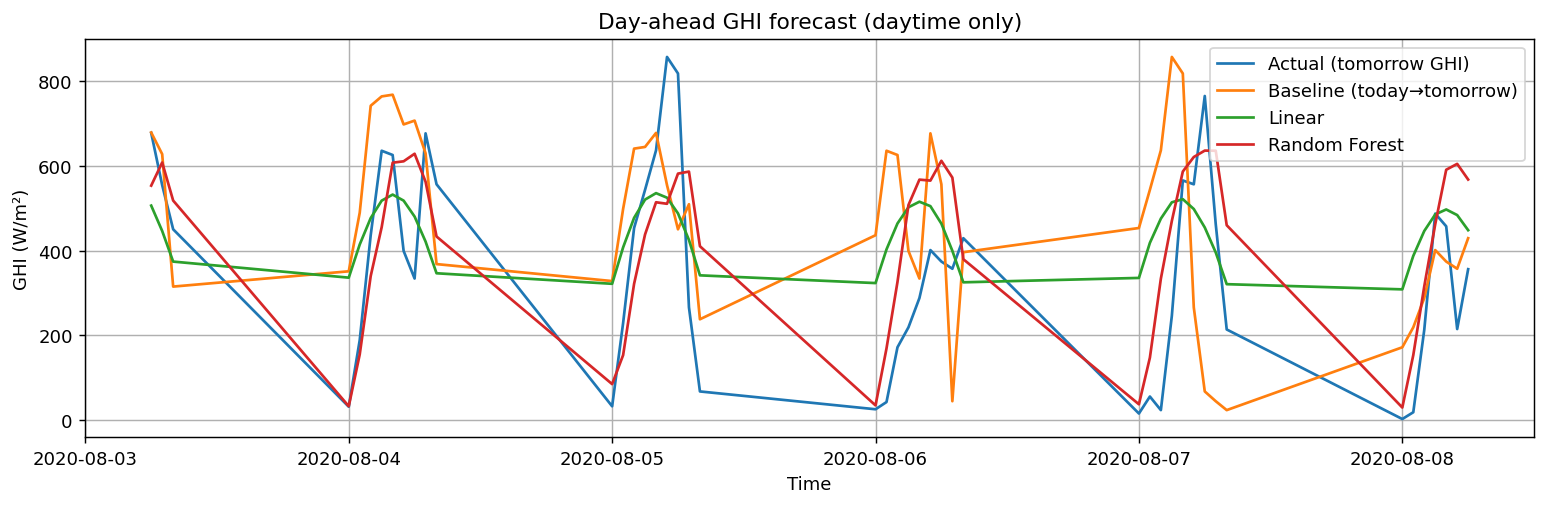

In [30]:
test_index = y_test.index
cs_test = df_da.loc[test_index, 'Clearsky GHI']

day_mask = cs_test > 300  # high-irradiance hours only

# Plot 5 days of daytime points
n_days = 5
mask_5d = day_mask.copy()
mask_5d.loc[mask_5d.index > mask_5d.index.min() + pd.Timedelta(days=n_days)] = False

idx = test_index[mask_5d]

plt.figure(figsize=(12,4))
plt.plot(idx, y_test.loc[idx], label="Actual (tomorrow GHI)")
plt.plot(idx, y_pred_base[mask_5d.values], label="Baseline (today→tomorrow)")
plt.plot(idx, y_pred_lin[mask_5d.values], label="Linear")
plt.plot(idx, y_pred_rf[mask_5d.values], label="Random Forest")
plt.title("Day-ahead GHI forecast (daytime only)")
plt.xlabel("Time")
plt.ylabel("GHI (W/m²)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('figures/ghi_day_ahead_forecast.png', dpi=150)
plt.show()


## Report skill vs Baseline

In [20]:
def skill(rmse_model, rmse_base):
    return 100.0 * (rmse_base - rmse_model) / rmse_base

print("Skill (Linear):", skill(rmse_lin, rmse_base), "%")
print("Skill (RF):", skill(rmse_rf, rmse_base), "%")


Skill (Linear): 19.686408012678385 %
Skill (RF): 34.736044502250934 %


## Results and discussion (Day-Ahead Solar Forecasting)

I reframed the task as a **day-ahead** problem: predicting hourly **GHI at t+24 hours** using only information available at time *t*. This avoids overly optimistic performance that can occur in hour-ahead forecasting due to short-term persistence.

**Performance (test set):**
- Baseline (persistence) RMSE: **271.52 W/m²**
- Linear regression RMSE: **218.07 W/m²** (≈ **19.7%** improvement vs baseline)
- Random Forest RMSE: **177.21 W/m²** (≈ **34.7%** improvement vs baseline)

### Interpretation

The baseline assumes tomorrow will look like today, which is often violated by day-to-day cloud evolution. The linear model improves skill by leveraging deterministic structure (solar geometry via time features + clear-sky reference) and coarse meteorological context.

Random Forest performs best because it can learn **nonlinear interactions** among predictors (e.g., how seasonality and meteorology modulate departures from clear-sky conditions). However, the remaining error is still large because day-ahead irradiance is fundamentally constrained by **unpredictable cloud variability** unless additional information (satellite cloud products, NWP cloud fields, sky images) is incorporated.


# Feature Importance (Day-Ahead RF)

In [21]:

feature_importance = pd.Series(
    rf.feature_importances_,
    index=FEATURE_COLS_DA
).sort_values(ascending=False)

feature_importance


Clearsky GHI         0.327763
dayofyear            0.221749
hour                 0.157274
Temperature          0.084848
Relative Humidity    0.045382
Wind Direction       0.045190
GHI_lag24            0.043141
GHI_roll24           0.040470
Wind Speed           0.027975
month                0.006209
dtype: float64

## Plot and save Feature Importance

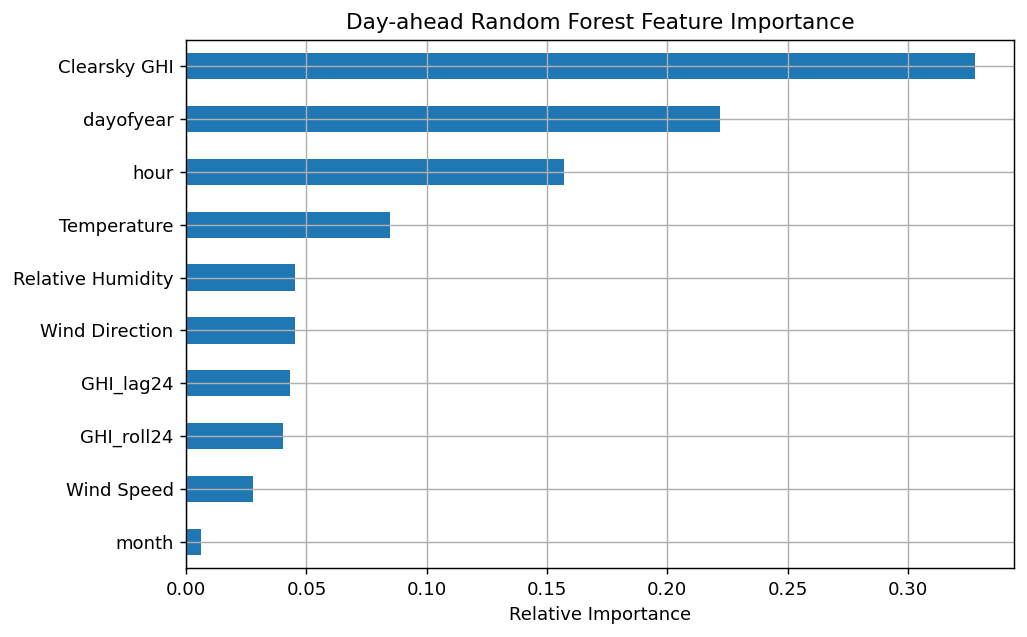

In [22]:
plt.figure(figsize=(8,5))
feature_importance.head(10).sort_values().plot(kind="barh")
plt.title("Day-ahead Random Forest Feature Importance")
plt.xlabel("Relative Importance")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"figures/rf_feature_importance_day_ahead.png", dpi=150)
plt.show()


## Feature importance discussion

From the feature importance plot, I see that **clear-sky GHI** and **time-of-year / time-of-day** features dominate day-ahead predictability, which is physically expected because solar geometry sets the upper envelope of irradiance.  

Lag-24 and rolling-24 history then capture regime persistence (e.g., multi-day cloudy vs clearer periods), while meteorological variables provide smaller nonlinear corrections. Overall, this pattern supports a physically consistent interpretation: the model learns solar geometry first, then adjusts for weather-driven departures.


# Convert GHI to PV Power

## Define a simple PV conversion model

In [23]:
# PV system assumptions
PV_EFFICIENCY = 0.18     # 18% typical crystalline silicon
PV_AREA = 10.0           # m² (small rooftop system)

def ghi_to_pv_power(ghi):
    """
    Convert GHI (W/m²) to PV power output (W)
    """
    return ghi * PV_AREA * PV_EFFICIENCY


## Compute Actual vs Predicted PV Power

In [24]:
pv_actual = ghi_to_pv_power(y_test)
pv_pred_rf = ghi_to_pv_power(y_pred_rf)
pv_pred_base = ghi_to_pv_power(y_pred_base)

### Plot PV Power (Daytime only)

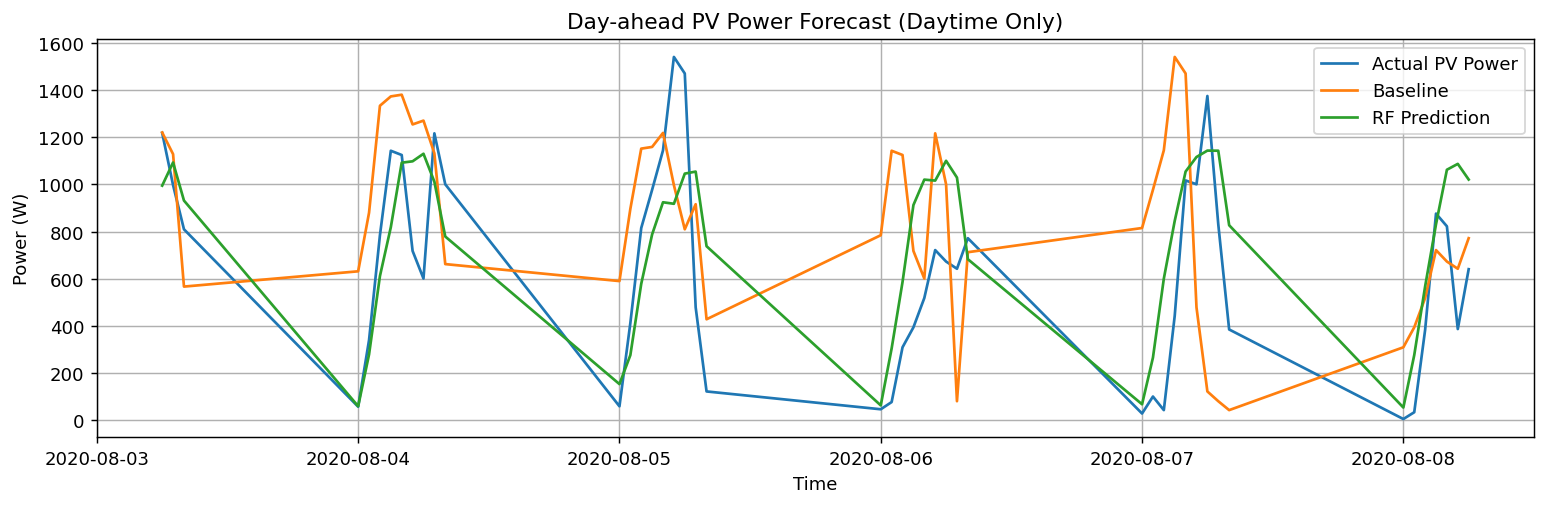

In [29]:
# Daytime-only for plotting
cs_test = df_da.loc[y_test.index, 'Clearsky GHI']
day_mask = cs_test > 300

# Plot first 5 days
n_days = 5
mask_5d = day_mask.copy()
mask_5d.loc[mask_5d.index > mask_5d.index.min() + pd.Timedelta(days=n_days)] = False
idx = y_test.index[mask_5d]

plt.figure(figsize=(12,4))
plt.plot(idx, pv_actual.loc[idx], label="Actual PV Power")
plt.plot(idx, pv_pred_base[mask_5d.values], label="Baseline")
plt.plot(idx, pv_pred_rf[mask_5d.values], label="RF Prediction")
plt.title("Day-ahead PV Power Forecast (Daytime Only)")
plt.grid(True)
plt.ylabel("Power (W)")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.savefig(f"figures/pv_power_day_ahead.png", dpi=150)
plt.show()


### Daily energy error

In energy planning, I often care more about **daily kWh** than hourly **W**, so I aggregate predicted and observed PV power into daily energy totals and examine the daily error.


In [26]:
# Convert to daily energy (Wh → kWh)
pv_df = pd.DataFrame({
    "actual": pv_actual,
    "pred_rf": pv_pred_rf
}, index=y_test.index)

daily_energy = pv_df.resample("D").sum() / 1000  # kWh

daily_energy.head()


,actual,pred_rf
datetime,,
2020-08-03,4.7682,4.342952
2020-08-04,8.1234,8.222467
2020-08-05,7.2558,7.862555
2020-08-06,4.9986,8.011309
2020-08-07,5.8410,8.413970


### Plot Daily PV Energy Error

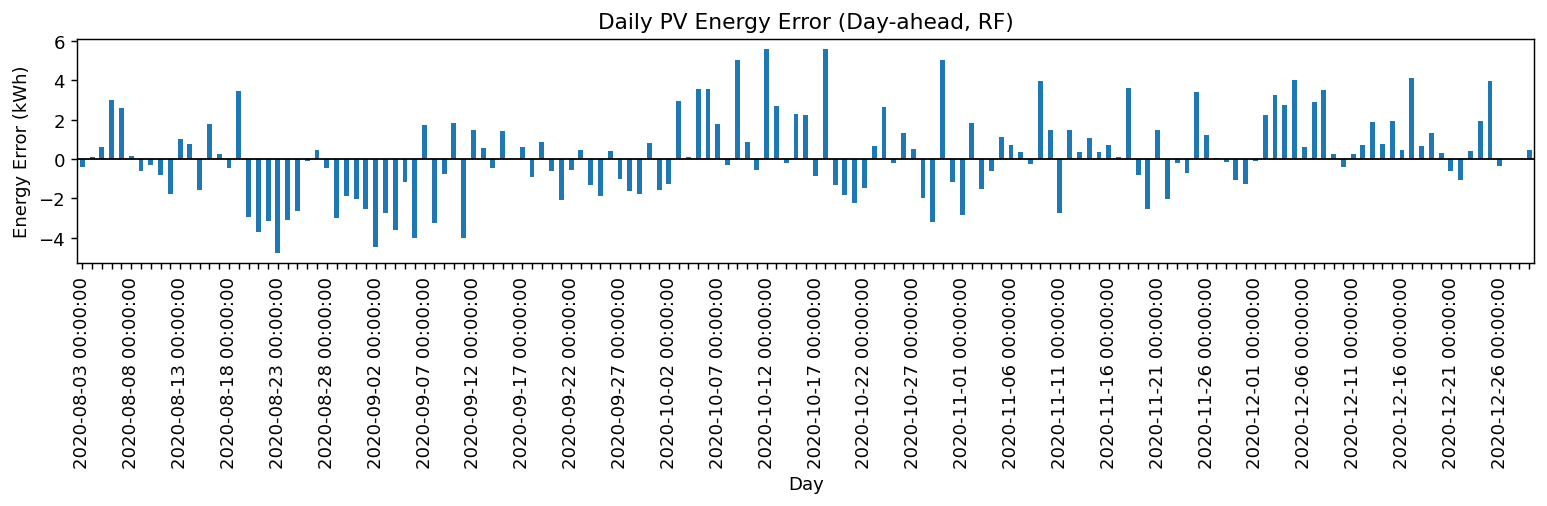

In [27]:
energy_error = daily_energy["pred_rf"] - daily_energy["actual"]

fig, ax = plt.subplots(figsize=(12,4))
energy_error.plot(kind="bar", ax=ax)

ax.axhline(0, color="black", linewidth=1)
ax.set_title("Daily PV Energy Error (Day-ahead, RF)")
ax.set_ylabel("Energy Error (kWh)")
ax.set_xlabel("Day")

# Show only every Nth label
N = 5  # label every 5 days
for i, label in enumerate(ax.get_xticklabels()):
    if i % N != 0:
        label.set_visible(False)

plt.tight_layout()
plt.savefig("figures/pv_daily_energy_error.png", dpi=150)
plt.show()


## PV conversion (why I do this)

To translate irradiance forecasts into an energy-relevant metric, I convert GHI into an estimated PV power output using a simplified fixed-efficiency model. This is idealized (no tilt/orientation losses, no temperature-dependent efficiency, no inverter clipping), but it makes the forecast easier to interpret in terms of **power (W)** and **daily energy (kWh)**—which is how solar performance is often discussed operationally.


# Executive Summary

Accurate day-ahead forecasts of solar energy availability are essential for grid operations, energy trading, and renewable integration, particularly in regions with strong cloud-driven variability. In this project, I developed a **day-ahead solar irradiance forecasting pipeline** using hourly data from the National Solar Radiation Database (NSRDB) for Metropolitan Manila, Philippines, and evaluated its performance against a meaningful persistence baseline.

The forecasting task was formulated as a **24-hour-ahead prediction problem**, where Global Horizontal Irradiance (GHI) at time *t+24* is predicted using only information available at time *t*. This formulation avoids the inflated performance commonly observed in hour-ahead forecasting due to short-term persistence and deterministic solar geometry. Predictors included calendar variables, meteorological conditions, clear-sky reference irradiance, and historical persistence at the daily scale.

Model performance was evaluated using a chronological 80/20 train–test split to preserve temporal causality. A persistence baseline assuming that tomorrow’s irradiance equals today’s irradiance at the same hour yielded an RMSE of **271.5 W/m²**, highlighting the inherent difficulty of day-ahead solar prediction in a tropical environment. A linear regression model reduced the RMSE to **218.1 W/m²**, corresponding to a **~20% improvement** over the baseline. The best performance was achieved by a Random Forest model, which attained an RMSE of **177.2 W/m²**, representing a **~35% reduction in error** relative to persistence.

Feature importance analysis indicates that clear-sky irradiance and diurnal/seasonal timing dominate predictability, reflecting the strong deterministic control of solar geometry. Meteorological variables contribute secondary nonlinear corrections associated with cloud modulation. Despite these improvements, substantial residual errors remain, emphasizing the intrinsic unpredictability of cloud evolution at day-ahead horizons.

To assess operational relevance, irradiance forecasts were converted into photovoltaic (PV) power and daily energy yield using a simplified fixed-efficiency PV model. This conversion demonstrates that even moderate improvements in irradiance forecast skill translate into meaningful differences in estimated daily energy production, while also illustrating the limits imposed by atmospheric variability.

Overall, this project demonstrates a **physically consistent, leakage-free, and operationally realistic approach to day-ahead solar forecasting**, providing a transparent benchmark for evaluating machine-learning models in renewable energy applications.


## References
- National Renewable Energy Laboratory (NREL). **National Solar Radiation Database (NSRDB)**  
  https://nsrdb.nrel.gov/

- Perez, R., et al. (2013). *Validation of the National Solar Radiation Database (NSRDB).*  
  Solar Energy, 93, 121–132.

- Lorenz, E., et al. (2014). *Regional photovoltaic power prediction for improved grid integration.*  
  IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing.

- Yang, D., et al. (2015). *Solar irradiance forecasting using time-series and machine learning methods.*  
  Renewable and Sustainable Energy Reviews, 44, 676–686.

- SolarAnywhere. *Solar Irradiance Data Field Definitions*.  
  Clean Power Research.  
  https://www.solaranywhere.com/support/data-fields/definitions/